# Microsoft Stock Price Prediction Model
The MSFT data is a 4 year worth of data from 2019-2023

In [89]:
#import necessary modules
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [90]:
# get dataset
df = pd.read_csv('data/MSFT.csv')
display(df.info(), 'Data Head', df.head(), 'Data Description', df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1020 non-null   object 
 1   Open       1020 non-null   float64
 2   High       1020 non-null   float64
 3   Low        1020 non-null   float64
 4   Close      1020 non-null   float64
 5   Adj Close  1020 non-null   float64
 6   Volume     1020 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 55.9+ KB


None

'Data Head'

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,99.550003,101.750000,98.940002,101.120003,96.874695,35329300
1,2019-01-03,100.099998,100.190002,97.199997,97.400002,93.310875,42579100
2,2019-01-04,99.720001,102.510002,98.930000,101.930000,97.650673,44060600
3,2019-01-07,101.639999,103.269997,100.980003,102.059998,97.775223,35656100
4,2019-01-08,103.040001,103.970001,101.709999,102.800003,98.484177,31514400


'Data Description'

,Open,High,Low,Close,Adj Close,Volume
count,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,1.020000e+03
mean,217.119618,219.420049,214.711265,217.177088,213.794872,2.989538e+07
std,64.922569,65.557039,64.155292,64.876109,65.636831,1.267774e+07
min,99.550003,100.190002,97.199997,97.400002,93.310875,8.989200e+06
25%,152.432502,155.867496,151.310005,154.489998,150.192452,2.190638e+07
50%,222.944999,225.774994,220.234993,223.074997,219.749168,2.699105e+07
75%,266.019989,268.307488,263.452507,266.659996,264.892158,3.389500e+07
max,344.619995,349.670013,342.200012,343.109985,339.924835,9.701270e+07


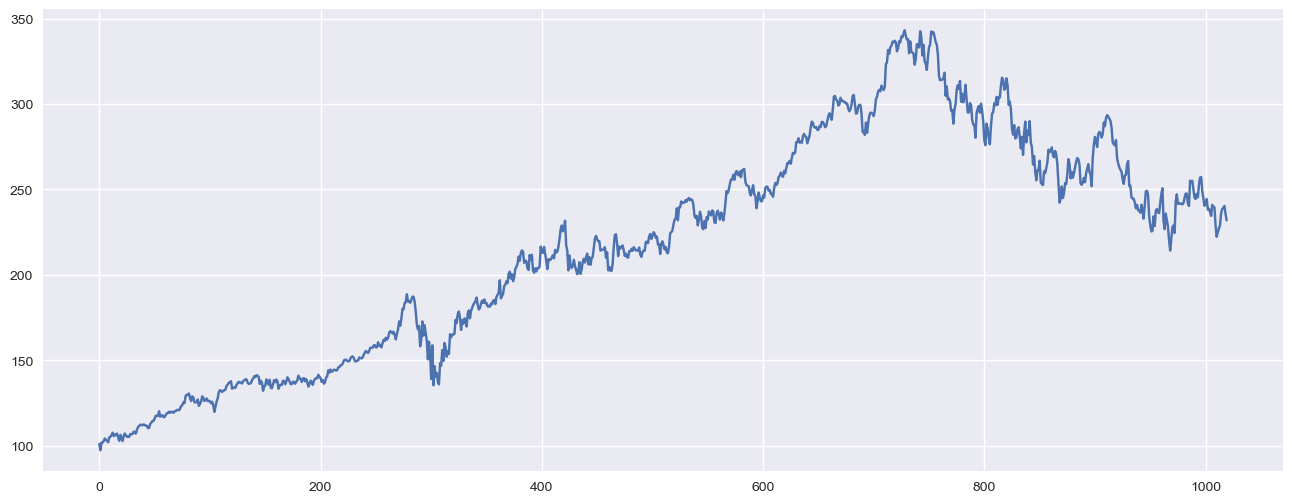

In [91]:
plt.figure(1, figsize=(16,6))
plt.plot(df.Close)

## Feature Enginering

##### Calculate percentage change

In [92]:
df["Returns"] = df.Close.pct_change()
df.Returns

0            NaN
1      -0.036788
2       0.046509
3       0.001275
4       0.007251
          ...   
1015    0.011621
1016    0.003019
1017    0.004682
1018   -0.018889
1019   -0.016454
Name: Returns, Length: 1020, dtype: float64

In [93]:
df["Log_Returns"] = np.log(1+df.Returns)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Returns,Log_Returns
0,2019-01-02,99.550003,101.750000,98.940002,101.120003,96.874695,35329300,NaN,NaN
1,2019-01-03,100.099998,100.190002,97.199997,97.400002,93.310875,42579100,-0.036788,-0.037482
2,2019-01-04,99.720001,102.510002,98.930000,101.930000,97.650673,44060600,0.046509,0.045460
3,2019-01-07,101.639999,103.269997,100.980003,102.059998,97.775223,35656100,0.001275,0.001275
4,2019-01-08,103.040001,103.970001,101.709999,102.800003,98.484177,31514400,0.007251,0.007225


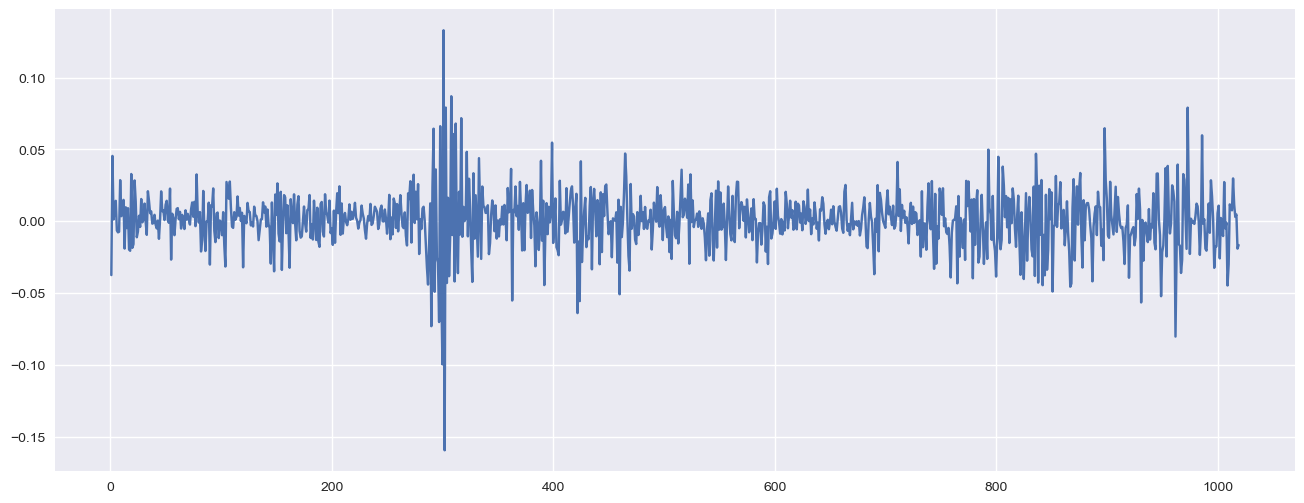

In [94]:
plt.figure(1, figsize=(16,6))
plt.plot(df.Log_Returns)

In [95]:
df.dropna(inplace=True)
X = df[['Close', 'Log_Returns']].values
X

array([[ 9.74000020e+01, -3.74817289e-02],
       [ 1.01930000e+02,  4.54600720e-02],
       [ 1.02059998e+02,  1.27455286e-03],
       ...,
       [ 2.40350006e+02,  4.67080375e-03],
       [ 2.35809998e+02, -1.90698318e-02],
       [ 2.31929993e+02, -1.65908157e-02]])

#### Data Preprocessing

In [96]:
from sklearn.preprocessing import MinMaxScaler

In [97]:
mms = MinMaxScaler(feature_range=(0, 1)).fit(X)
X = mms.transform(X)
y = [x[0] for x in X]
X[:5]

array([[0.        , 0.41716495],
       [0.01843636, 0.70084072],
       [0.01896543, 0.54971835],
       [0.02197713, 0.57006832],
       [0.02795977, 0.5939198 ]])

In [98]:
y[:5]

[0.0,
 0.01843636121207176,
 0.01896543210456364,
 0.021977133098413815,
 0.027959771581604786]

In [99]:
# Split train test
split = int(len(X)*0.8)
X_train = X[:split]
X_test = X[split:len(X)]
y_train = y[:split]
y_test = y[split:len(y)]
print(f"X train size {X_train.shape[0]} X test size {X_test.shape[0]}\
    y train size {len(y_train)} y test size {len(y_test)}")

X train size 815 X test size 204    y train size 815 y test size 204


We want to predict the stock price at a future time, we'll predict the stock price at time t+1  relative to the stock price at time t, here will use the previous three records n=3 to predict our next price 

In [100]:
n = 3
Xtrain = []
Xtest = []
ytrain = []
ytest = []
for i in range(n, len(X_train)):
    Xtrain.append(X_train[i-n : i : X_train.shape[1]])
    ytrain.append(y_train[i])
for i in range(n, len(X_test)):
    Xtest.append(X_test[i-n : i : X_test.shape[1]])
    ytest.append(y_test[i])

display('X train previous price',  Xtrain[0], 'Y train predicted price', ytrain[0])

'X train previous price'

array([[0.        , 0.41716495],
       [0.01896543, 0.54971835]])

'Y train predicted price'

0.021977133098413815

In [101]:
# lets check how our y prices look after inverse transform
next_price = np.array(ytrain[0])
next_price = np.c_[next_price, np.zeros(next_price.shape)]
next_price = mms.inverse_transform(next_price)
display(df.head(), 'y price', next_price)


,Date,Open,High,Low,Close,Adj Close,Volume,Returns,Log_Returns
1,2019-01-03,100.099998,100.190002,97.199997,97.400002,93.310875,42579100,-0.036788,-0.037482
2,2019-01-04,99.720001,102.510002,98.930000,101.930000,97.650673,44060600,0.046509,0.045460
3,2019-01-07,101.639999,103.269997,100.980003,102.059998,97.775223,35656100,0.001275,0.001275
4,2019-01-08,103.040001,103.970001,101.709999,102.800003,98.484177,31514400,0.007251,0.007225
5,2019-01-09,103.860001,104.879997,103.239998,104.269997,99.892441,32280800,0.014300,0.014198


'y price'

array([[102.800003  ,  -0.15945342]])

In [102]:
Xtrain, ytrain = (np.array(Xtrain), np.array(ytrain))
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], Xtrain.shape[2]))
Xtest, ytest = (np.array(Xtest), np.array(ytest))
Xtest = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], Xtest.shape[2]))

Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape

((812, 2, 2), (812,), (201, 2, 2), (201,))

## LSTM Model

In [107]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

In [104]:
model = Sequential()
model.add(LSTM(4, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(Xtrain, ytrain, epochs=100, validation_data=(Xtest, ytest), verbose=1, batch_size=16)

Epoch 1/100
51/51 [==============================] - 3s 22ms/step - loss: 0.4282 - val_loss: 0.5127
Epoch 2/100
51/51 [==============================] - 0s 7ms/step - loss: 0.2609 - val_loss: 0.3103
Epoch 3/100
51/51 [==============================] - 0s 5ms/step - loss: 0.1564 - val_loss: 0.1706
Epoch 4/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0954 - val_loss: 0.0831
Epoch 5/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0693 - val_loss: 0.0423
Epoch 6/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0602 - val_loss: 0.0285
Epoch 7/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0545 - val_loss: 0.0238
Epoch 8/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0492 - val_loss: 0.0201
Epoch 9/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0437 - val_loss: 0.0174
Epoch 10/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0381 - val_loss: 0.0150
Epoch 11

In [105]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 4)                 112       
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 117
Trainable params: 117
Non-trainable params: 0
_________________________________________________________________


In [108]:
preds = model.predict(Xtest)

7/7 [==============================] - 1s 2ms/step


In [114]:
score = mean_squared_error(ytest, preds, squared=False)
score

0.02974242320901805